In [23]:
import torch
from torchvision import transforms
from PIL import Image

image_path = "drive/MyDrive/edge-ready.jpg"
image = Image.open(image_path)

In [2]:
preprocess = transforms.Compose([transforms.ToTensor()])
input_tensor = preprocess(image)

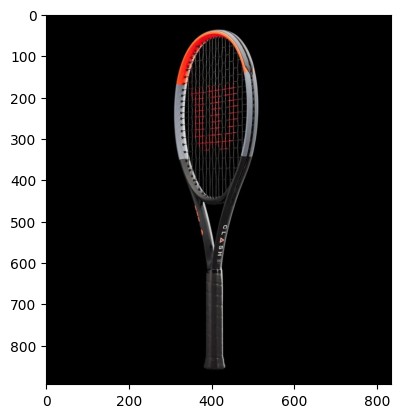

In [3]:
import matplotlib.pyplot as plt

plt.imshow(input_tensor.permute(1, 2, 0))
plt.show()

torch.Size([1, 894, 835])


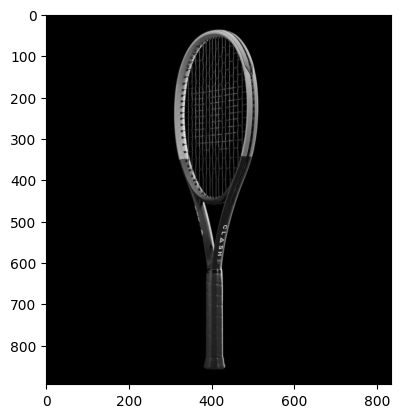

In [4]:
import torch.nn as nn

conv1x1 = nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0)

weights = torch.tensor([0.2989, 0.5870, 0.1140])
conv1x1.weight.data[0] = weights.view(1, 3, 1, 1)

grayscale_image = conv1x1(input_tensor)
print(grayscale_image.shape)
plt.imshow(grayscale_image[0].detach().numpy(), cmap='gray')
plt.show()

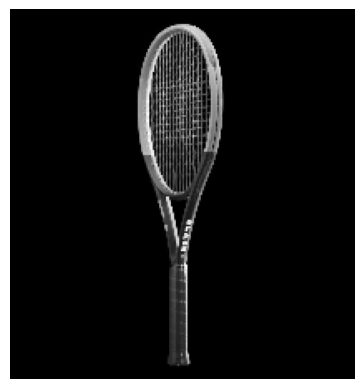

In [5]:
import torch.nn.functional as F

pooled_tensor = F.max_pool2d(grayscale_image, kernel_size=4)

plt.imshow(pooled_tensor[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

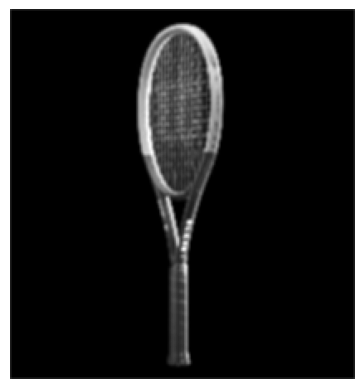

In [9]:
import numpy as np

n = 3

sigma = 1.0
gaussian_filter = np.fromfunction(
    lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - n//2) ** 2 + (y - n//2) ** 2) / (2 * sigma ** 2)),
    (n, n)
)

gaussian_filter = gaussian_filter / np.sum(gaussian_filter)

gaussian_filter = torch.FloatTensor(gaussian_filter).view(1, 1, n, n)

blurred_image = F.conv2d(pooled_tensor, gaussian_filter, padding=n//2)

plt.imshow(blurred_image[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

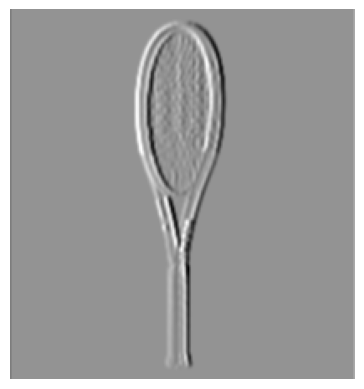

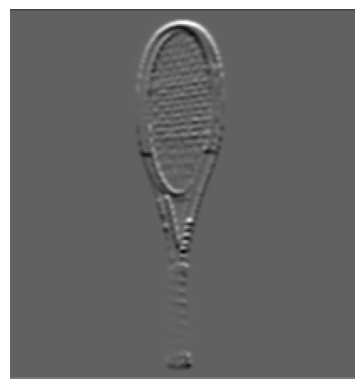

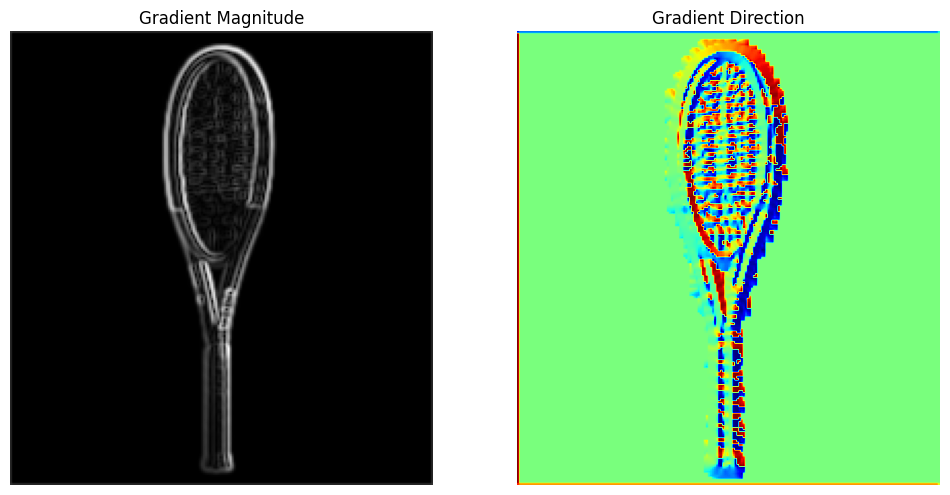

In [33]:
sobel_horizontal = torch.FloatTensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_vertical = torch.FloatTensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

horizontal_gradient = nn.functional.conv2d(blurred_image, sobel_horizontal.view(1, 1, 3, 3))
vertical_gradient = nn.functional.conv2d(blurred_image, sobel_vertical.view(1, 1, 3, 3))

gradient_magnitude = torch.sqrt(horizontal_gradient**2 + vertical_gradient**2)
gradient_direction = torch.atan2(vertical_gradient, horizontal_gradient)

plt.imshow(horizontal_gradient[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(vertical_gradient[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gradient_magnitude[0].detach().numpy(), cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradient_direction[0].detach().numpy(), cmap='jet', aspect='equal')
plt.title('Gradient Direction')
plt.axis('off')

plt.show()

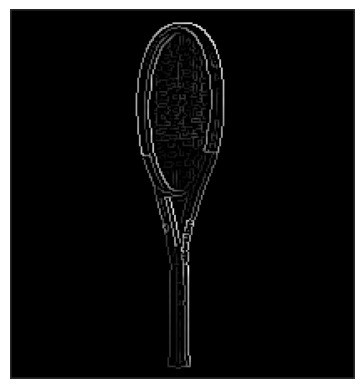

In [11]:
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    h, w = gradient_magnitude.shape[-2:]

    suppressed = gradient_magnitude.clone()

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            angle = gradient_direction[0, i, j]
            if (angle >= -np.pi/8 and angle < np.pi/8) or (angle >= 7*np.pi/8) or (angle < -7*np.pi/8):
                neighbors = [gradient_magnitude[0, i, j-1], gradient_magnitude[0, i, j+1]]
            elif (angle >= np.pi/8 and angle < 3*np.pi/8) or (angle < -5*np.pi/8 and angle >= -7*np.pi/8):
                neighbors = [gradient_magnitude[0, i-1, j-1], gradient_magnitude[0, i+1, j+1]]
            elif (angle >= 3*np.pi/8 and angle < 5*np.pi/8) or (angle < -3*np.pi/8 and angle >= -5*np.pi/8):
                neighbors = [gradient_magnitude[0, i-1, j], gradient_magnitude[0, i+1, j]]
            else:
                neighbors = [gradient_magnitude[0, i-1, j+1], gradient_magnitude[0, i+1, j-1]]

            if gradient_magnitude[0, i, j] <= max(neighbors):
                suppressed[0, i, j] = 0

    return suppressed

suppressed_magnitude = non_maximum_suppression(gradient_magnitude, gradient_direction)

plt.imshow(suppressed_magnitude[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

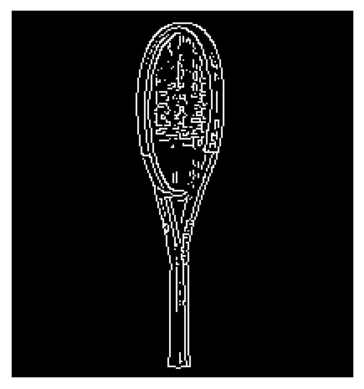

In [31]:
threshold = 0.3
thresholded_edges = (suppressed_magnitude > threshold).float()

plt.imshow(thresholded_edges[0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

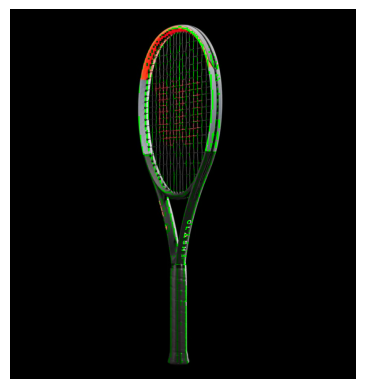

In [29]:
upscaled_edges = F.interpolate(thresholded_edges.unsqueeze(0), size=(image.height, image.width))

enhanced_image = input_tensor.clone()
tmp = upscaled_edges + 1
enhanced_image[1] = input_tensor[1]  * tmp
enhanced_image[0] = input_tensor[0] * (1 - upscaled_edges)
enhanced_image[2] = input_tensor[2] * (1 - upscaled_edges)

plt.imshow(enhanced_image.permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()

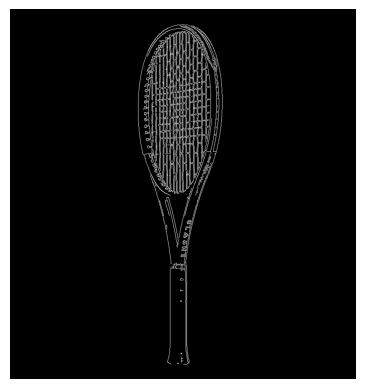

In [22]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("drive/MyDrive/edge-ready.jpg", cv2.IMREAD_COLOR)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

canny_edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

plt.imshow(canny_edges, cmap='gray')
plt.axis('off')
plt.show()